### Import packages

In [11]:
import osmnx as ox
import math
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import folium
from pathlib import Path

### Load barrios y puntos CID

In [12]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"Archivo no encontrado: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' cargado correctamente ({len(gdf)} registros)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error al cargar '{nombre_archivo}': {str(e)}")
        return None
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' cargado correctamente (88 registros)
✅ 'catastro.geojson' cargado correctamente (36346 registros)
✅ 'puntosCID.geojson' cargado correctamente (885 registros)


### Functions

In [13]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.upper() == request.upper()]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.upper() == request.upper()]
    shp_zone = shp_neighbourhood["geometry"].values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(shp_zone, 
                              network_type="all_public",  
                              simplify=False, 
                              retain_all=False,  
                              truncate_by_edge=True) 
    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']

    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street',
                    'primary_link', 'primary', 'tertiary', 'trunk', 'service',
                    'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    
    allowed_pedestrian = ["pedestrian", "footway", "path", "track", "bridleway"]
    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()  
    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True) 
                                   if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)
    
    G_pedestrian = G.copy()  
    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True) 
                                      if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    print(f"Grafo para vehículos: {len(G_vehicle.nodes)} nodos, {len(G_vehicle.edges)} aristas")
    print(f"Grafo para peatones: {len(G_pedestrian.nodes)} nodos, {len(G_pedestrian.edges)} aristas")
    

    fig, ax = plt.subplots(2,1, figsize=(20, 15))
    
    ax[0].set_title("Grafo para vehículos")
    ox.plot_graph(G_vehicle, ax=ax[0], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)

    ax[1].set_title("Grafo para peatones")
    ox.plot_graph(G_pedestrian, ax=ax[1], node_size=3, node_color='green', 
                  edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    
    plt.show()
    
    return G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos
    



def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)
    
    bajos_in_zone = bajos[bajos.intersects(shp_zone)]
    
    for grafo, color in [(gdf_edges_vehicle, "blue"), (gdf_edges_pedestrian, "red")]:
        for _, row in grafo.iterrows():
            if row["geometry"].geom_type == "LineString":
                puntos = [(p[1], p[0]) for p in row["geometry"].coords]
                folium.PolyLine(puntos, weight=2, opacity=1, color=color).add_to(mapa)

    folium.GeoJson(
        shp_zone,  
        style_function=lambda feature: {
            "color": "green", 
            "weight": 6,  
            "fill": True,  
            "fillColor": "limegreen",  
            "fillOpacity": 0.2  
        }
    ).add_to(mapa)

    shp_loading_points.apply(lambda row: folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x], 
        radius=8,  
        color="black",  
        fill=True,
        fill_color="orange",  
        fill_opacity=1, 
        popup=row.get("NOMBRE", "Punto de carga")
    ).add_to(mapa), axis=1)

    COLOR_CARGA = 'blue'  # Cambiado de orange a blue
    COLOR_ENTREGA = 'red'  # Cambiado de purple a red

    # Iterar sobre los bajos seleccionados
    for _, row in bajos_in_zone.sample(n=len(bajos_in_zone) // 5, random_state=None).iterrows():
    # Saltar puntos sin tipo
        if not row['Almacen'] and not row['Comercio']:
            continue
            
        centroide = row.geometry.centroid
        
        # Determinar color según las condiciones
        if row['Almacen'] and row['Comercio']:
            fill_color = 'black'
            tipo = "Almacén y Comercio"
        elif row['Almacen']:
            fill_color = 'purple'
            tipo = "Almacén"
        elif row['Comercio']:
            fill_color = 'lightblue'
            tipo = "Comercio"
        
        # Crear el marcador con borde negro
        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=8,
            color='black',  # Borde siempre negro
            fill=True,
            fill_color=fill_color,
            fill_opacity=1,
            popup=tipo
        ).add_to(mapa)

        # Leyenda actualizada
    legend_html = '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 250px; height: 130px; 
                            background-color: white; z-index:9999; font-size:13px;
                            border:1px solid grey; border-radius: 5px; padding: 8px;
                            box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
                    <b style="font-size:14px;">Leyenda</b> <br>
                    <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Almacén y Comercio <br>
                    <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Almacén (origen) <br>
                    <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Comercio (entrega) <br>
                    <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Barrio
                </div>
                '''
    mapa.get_root().html.add_child(folium.Element(legend_html))
    
    return mapa

### Get the graph

| FAVARA               | BENICALAP             | SANT PAU                 | BORBOTO                  | BENIFARAIG               |
|----------------------|----------------------|--------------------------|--------------------------|--------------------------|
| CAMI REAL           | JAUME ROIG            | LA SEU                   | AIORA                    | TORMOS                   |
| LA FONTETA S.LLUIS  | LA PETXINA            | L'HORT DE SENABRE        | CIUTAT JARDI             | CAMI DE VERA             |
| LA PUNTA            | SANT MARCEL.LI        | FAITANAR                 | PINEDO                   | CASTELLAR-L'OLIVERAL     |
| BENIMAMET           | EL FORN D'ALCEDO      | MONTOLIVET               | CIUTAT DE LES ARTS I DE LES CIENCIES | NA ROVELLA             |
| SANT LLORENS        | NATZARET              | LA CREU COBERTA          | L'AMISTAT                | EL GRAU                  |
| CIUTAT FALLERA      | RAFALELL-VISTABELLA   | LA CARRASCA              | BENIFERRI                | EL SALER                 |
| NOU MOLES           | MORVEDRE              | TRINITAT                 | CAMPANAR                 | EL CARME                 |
| LA LLUM             | LA VEGA BAIXA         | LA XEREA                 | L'ILLA PERDUDA           | TRES FORQUES             |
| LA MALVA-ROSA       | EL MERCAT             | LA ROQUETA               | LA GRAN VIA              | CAMI FONDO               |
| EL CALVARI          | LA RAIOSA             | SAFRANAR                 | SANT ISIDRE              | MALILLA                  |
| LES TENDETES        | PATRAIX               | RUSSAFA                  | LA CREU DEL GRAU         | LES CASES DE BARCENA     |
| CIUTAT UNIVERSITARIA | MAHUELLA-TAULADELLA  | MASSARROJOS              | CARPESA                  | TORREFIEL                |
| EL BOTANIC          | SANT ANTONI           | BENIMACLET               | MARXALENES               | EXPOSICIO                |
| BETERO              | CABANYAL-CANYAMELAR   | MESTALLA                 | EL PILAR                 | EL PLA DEL REMEI         |
| ALBORS              | ARRANCAPINS           | EN CORTS                 | POBLE NOU                | LA TORRE                 |
| SANT FRANCESC       | PENYA-ROJA            | ELS ORRIOLS              | VARA DE QUART            | SOTERNES                 |
| LA FONTSANTA        | EL PERELLONET         | EL PALMAR                | LA XEREA                 | L'ILLA PERDUDA           |


Grafo para vehículos: 775 nodos, 915 aristas
Grafo para peatones: 767 nodos, 1678 aristas


ImportError: matplotlib must be installed as an optional dependency for visualization.

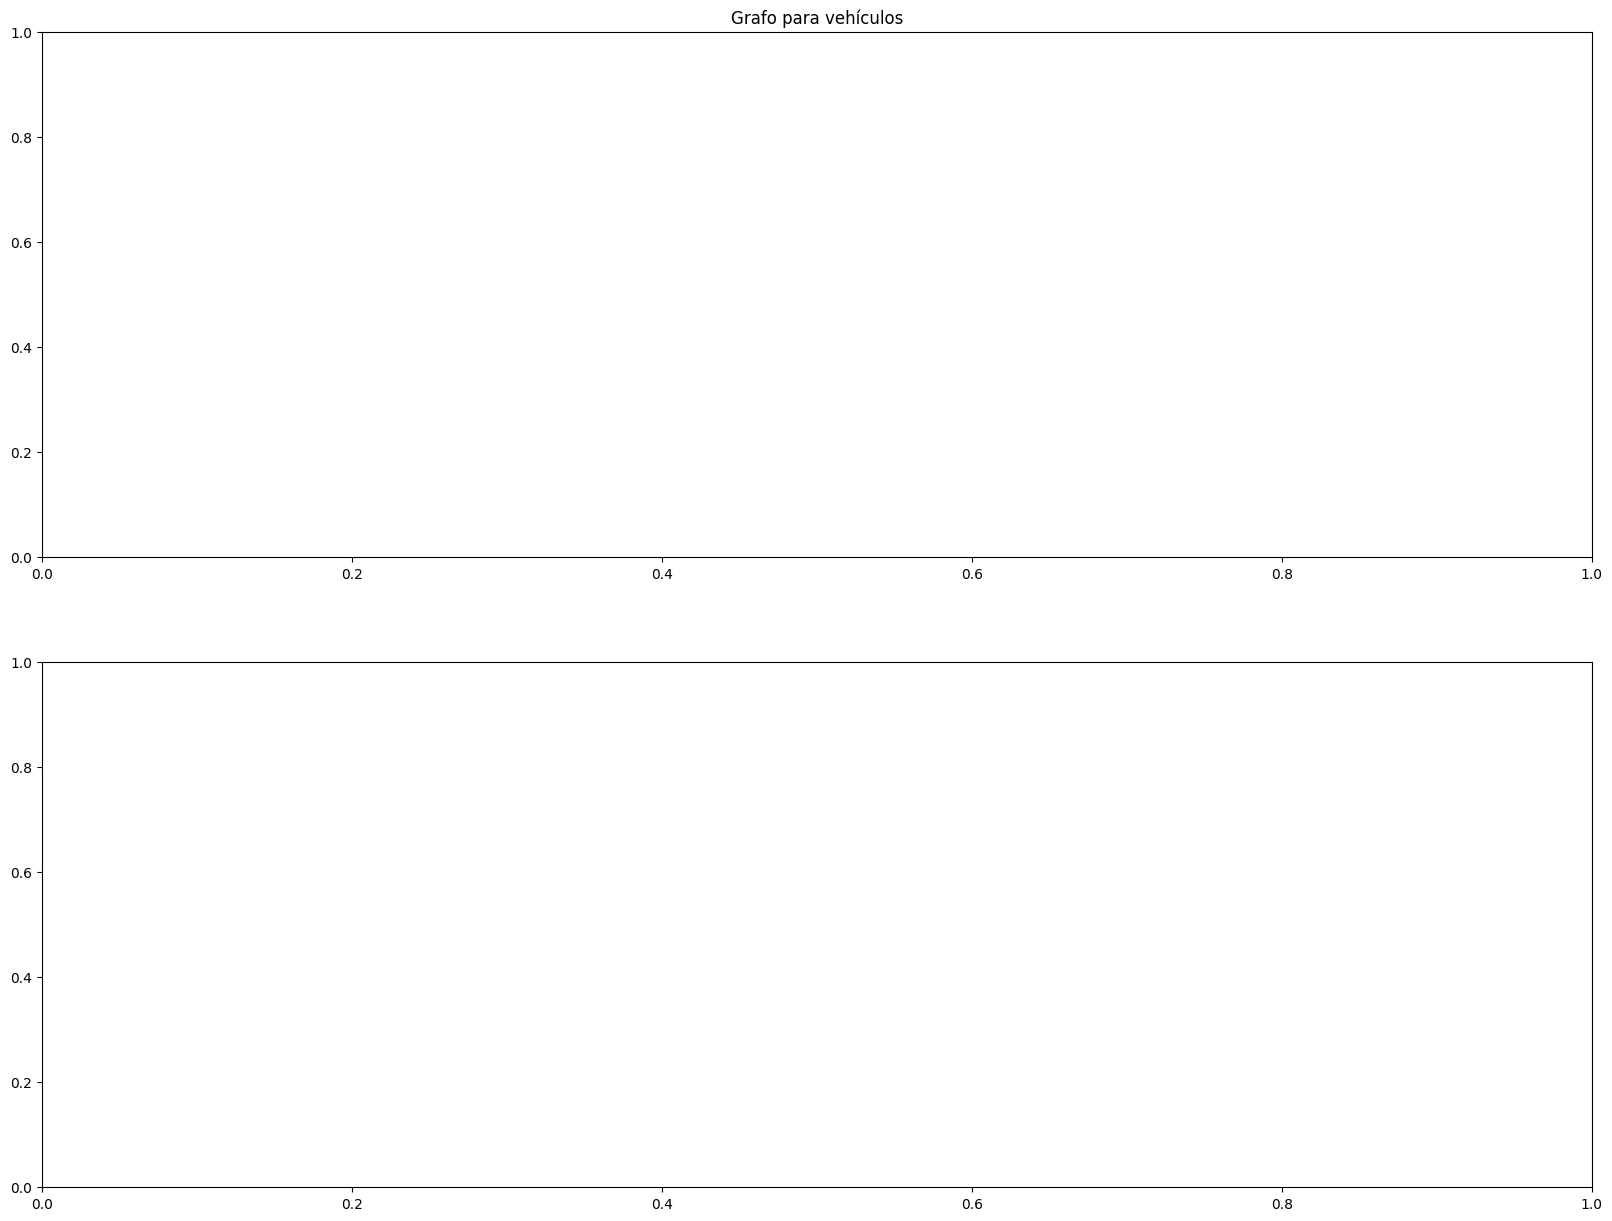

In [17]:
G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos= get_graph('Benimaclet')
graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos)

In [ ]:
import networkx as nx
from shapely.geometry import Point
import numpy as np


# ==============================
# 1. Crear el supergrafo
# ==============================

# Copiar los dos grafos
G_drive = G_vehicle.copy()
G_walk = G_pedestrian.copy()

# Etiquetar aristas
for u, v, k, data in G_drive.edges(keys=True, data=True):
    data['mode'] = 'drive'

for u, v, k, data in G_walk.edges(keys=True, data=True):
    data['mode'] = 'walk'

# Unir los dos grafos
G_super = nx.compose(G_drive, G_walk)

# ==============================
# 2. Añadir nodos especiales (con grafo correspondiente)
# ==============================

def add_special_node(G, geom, tipo, id_):
    """Añade un nodo especial (punto carga, comercio, almacén) y lo conecta"""
    nodo_id = f"{tipo}_{id_}"
    G.add_node(nodo_id, x=geom.centroid.x, y=geom.centroid.y, tipo=tipo)

    # Seleccionar grafo de conexión según tipo
    if tipo == "carga":
        grafo_conexion = G_drive
    else:
        grafo_conexion = G_walk

    # Buscar nodo más cercano
    nearest = ox.nearest_nodes(grafo_conexion, geom.centroid.x, geom.centroid.y)
    nearest_data = grafo_conexion.nodes[nearest]
    distance = Point(geom.centroid.x, geom.centroid.y).distance(Point(nearest_data['x'], nearest_data['y'])) * 111000  # m aprox

    # Añadir arista de conexión
    G.add_edge(nodo_id, nearest, mode='connection', length=distance)
    G.add_edge(nearest, nodo_id, mode='connection', length=distance)  # bidireccional

    return nodo_id

# Añadir puntos de carga
nodos_carga = []
for i, row in shp_loading_points.iterrows():
    nodo = add_special_node(G_super, row.geometry, "carga", i)
    nodos_carga.append(nodo)

# Añadir comercios
nodos_comercios = []
for i, row in shp_bajos[shp_bajos['Comercio'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "comercio", i)
    nodos_comercios.append(nodo)

# Añadir almacenes
nodos_almacenes = []
for i, row in shp_bajos[shp_bajos['Almacen'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "almacen", i)
    nodos_almacenes.append(nodo)

print(f"✅ Supergrafo creado con {len(G_super.nodes)} nodos y {len(G_super.edges)} aristas.")


✅ Supergrafo creado con 2042 nodos y 3831 aristas.


C:\Users\jagui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


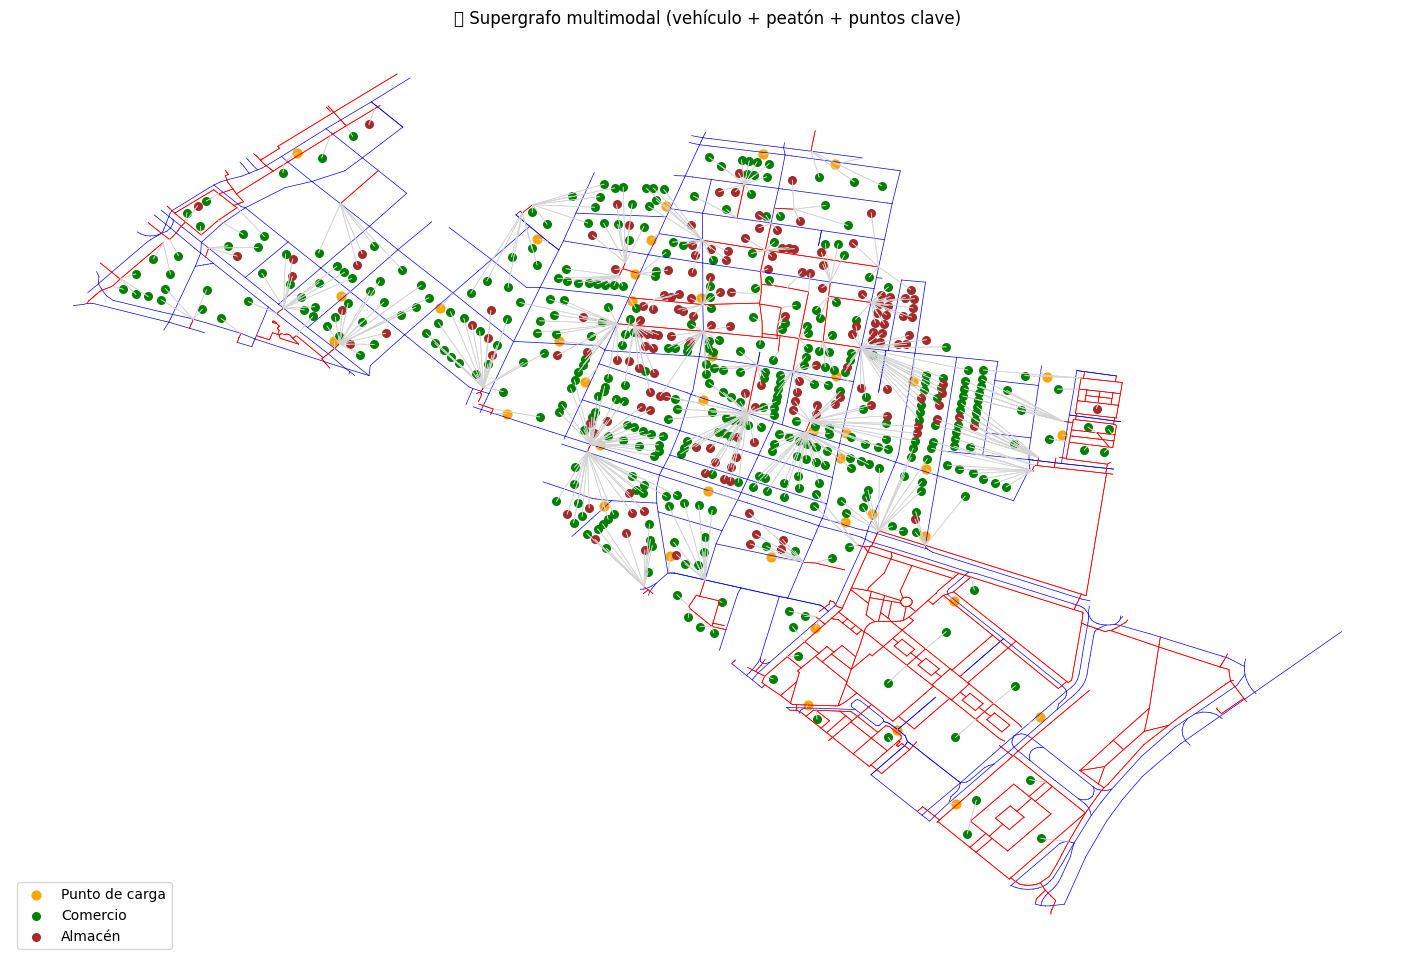

In [ ]:
import matplotlib.pyplot as plt

# ==========================
# Visualización del supergrafo
# ==========================

fig, ax = plt.subplots(figsize=(18, 12))

# Pintar aristas por tipo
for u, v, data in G_super.edges(data=True):
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    color = 'gray'
    if data['mode'] == 'drive':
        color = 'blue'
    elif data['mode'] == 'walk':
        color = 'red'
    elif data['mode'] == 'connection':
        color = 'lightgray'
    ax.plot([x0, x1], [y0, y1], color=color, linewidth=0.5)

# Pintar nodos especiales
for nodo, data in G_super.nodes(data=True):
    if isinstance(nodo, str):
        if data['tipo'] == 'carga':
            ax.scatter(data['x'], data['y'], color='orange', s=40, label='Punto de carga')
        elif data['tipo'] == 'comercio':
            ax.scatter(data['x'], data['y'], color='green', s=30, label='Comercio')
        elif data['tipo'] == 'almacen':
            ax.scatter(data['x'], data['y'], color='brown', s=30, label='Almacén')

# Leyenda limpia
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left')

ax.set_title("🗺️ Supergrafo multimodal (vehículo + peatón + puntos clave)")
ax.axis('off')
plt.show()


⚠️ Ningún comercio alcanzable desde la posición actual.

🏠 Nodo HUB (almacén más céntrico): almacen_27366
⏱️ Tiempo total estimado: 77.4 min

📦 Resumen entregas:
       paquetes
26665         4
28741         1
28771         4
26085         1
25633         4
29005         3
28605         4
27394         3
24827         3
25613         3


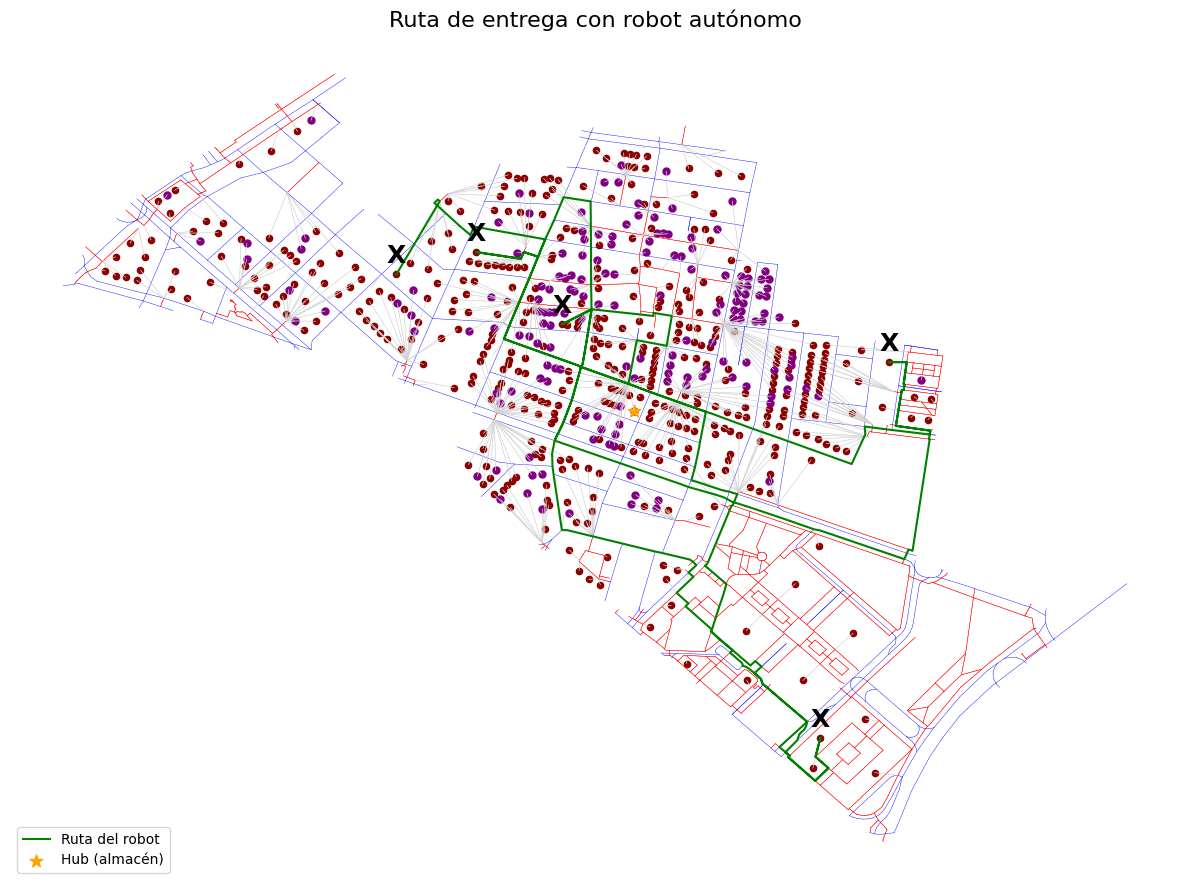

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point

# ==============================
# CONFIGURACIÓN
# ==============================

N_COMERCIOS = 10
PAQUETES_MIN = 1
PAQUETES_MAX = 5
VELOCIDAD_ROBOT = 5  # km/h
CAPACIDAD_ROBOT = 8  # paquetes

# ==============================
# 1. Seleccionar comercios y asignar paquetes
# ==============================

bajos_entrega = shp_bajos[shp_bajos['Comercio'] == True].copy()
bajos_sample = bajos_entrega.sample(n=N_COMERCIOS, random_state=42).copy()
bajos_sample['paquetes'] = np.random.randint(PAQUETES_MIN, PAQUETES_MAX + 1, size=N_COMERCIOS)

# ==============================
# 2. Determinar nodo HUB (almacén más centrado)
# ==============================

centroide_barrio = shp_zone.centroid

# Buscar el nodo 'almacen_*' más cercano al centroide
nodos_almacen = [n for n, d in G_super.nodes(data=True) if isinstance(n, str) and d.get('tipo') == 'almacen']

distancias_hub = {
    nodo: Point(G_super.nodes[nodo]['x'], G_super.nodes[nodo]['y']).distance(centroide_barrio)
    for nodo in nodos_almacen
}
hub_nodo = min(distancias_hub, key=distancias_hub.get)

# ==============================
# 3. Simulación de entrega con robot
# ==============================

ruta_total = []
tiempo_total = 0
pos_actual = hub_nodo
pendientes = bajos_sample.copy()
nodos_comercios = [f"comercio_{i}" for i in pendientes.index]

while not pendientes.empty:
    carga_actual = 0
    entregas_ruta = []

    for idx, row in pendientes.iterrows():
        nodo_comercio = f"comercio_{idx}"
        paquetes = row['paquetes']

        if carga_actual + paquetes <= CAPACIDAD_ROBOT:
            if nx.has_path(G_super, pos_actual, nodo_comercio):
                entregas_ruta.append(idx)
                carga_actual += paquetes

    if not entregas_ruta:
        print("⚠️ Ningún comercio alcanzable desde la posición actual.")
        break

    for idx in entregas_ruta:
        nodo_comercio = f"comercio_{idx}"
        try:
            camino = nx.shortest_path(G_super, pos_actual, nodo_comercio, weight='length')
            distancia = sum(
                G_super.edges[camino[i], camino[i + 1], 0]['length'] for i in range(len(camino) - 1)
            )
            tiempo = distancia / (VELOCIDAD_ROBOT * 1000 / 60)
            tiempo_total += tiempo
            ruta_total += camino[1:]
            pos_actual = nodo_comercio
        except Exception as e:
            print(f"❌ Error en ruta al comercio {idx}: {e}")
            continue

    pendientes = pendientes.drop(entregas_ruta)

# ==============================
# 4. Resultados
# ==============================

print(f"\n🏠 Nodo HUB (almacén más céntrico): {hub_nodo}")
print(f"⏱️ Tiempo total estimado: {tiempo_total:.1f} min")
print("\n📦 Resumen entregas:")
print(bajos_sample[['paquetes']])

# ==============================
# 5. Visualización de la ruta
# ==============================

fig, ax = plt.subplots(figsize=(12, 9))

# Pintar aristas del grafo
for u, v, data in G_super.edges(data=True):
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    color = 'gray'
    if data['mode'] == 'drive':
        color = 'blue'
    elif data['mode'] == 'walk':
        color = 'red'
    elif data['mode'] == 'connection':
        color = 'lightgray'
    ax.plot([x0, x1], [y0, y1], color=color, linewidth=0.3)

# Pintar nodos especiales (comercios y almacenes)
for nodo, data in G_super.nodes(data=True):
    if isinstance(nodo, str):
        if data['tipo'] == 'comercio':
            ax.scatter(data['x'], data['y'], color='darkred', s=20)
        elif data['tipo'] == 'almacen':
            ax.scatter(data['x'], data['y'], color='purple', s=25)

# Pintar la ruta del robot
if ruta_total:
    ruta_coords = [(G_super.nodes[n]['x'], G_super.nodes[n]['y']) for n in ruta_total]
    xs, ys = zip(*ruta_coords)
    ax.plot(xs, ys, color='green', linewidth=1.5, label='Ruta del robot')

    # Detectar y numerar los comercios en orden de visita
    nodos_visitados = []
    for n in ruta_total:
        if isinstance(n, str) and n.startswith("comercio_") and n not in nodos_visitados:
            nodos_visitados.append(n)

    for i, nodo in enumerate(nodos_visitados):
        x, y = G_super.nodes[nodo]['x'], G_super.nodes[nodo]['y']
        ax.annotate('X', (x, y), textcoords="offset points", xytext=(0, 8),
                    ha='center', fontsize=18, fontweight='bold', color='black')
else:
    print("⚠️ No se pudo generar una ruta válida para el robot.")

# Marcar el nodo HUB
hub_coords = (G_super.nodes[hub_nodo]['x'], G_super.nodes[hub_nodo]['y'])
ax.scatter(*hub_coords, color='orange', s=90, label='Hub (almacén)', marker='*')

# Leyenda y presentación
ax.legend(loc='lower left')
ax.set_title("Ruta de entrega con robot autónomo", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()
